In [1]:
# Make all the imports
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import roc_curve, auc

%matplotlib inline

In [2]:
# Read the datasets
with open('/logins.json') as data_file:
    data = json.loads(data_file.read())
logins = pd.DataFrame(data)

with open('/ultimate_data_challenge.json') as data_file:
    data2 = json.loads(data_file.read())
challenge = pd.DataFrame(data2)

## Part 1

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.



In [3]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null object
dtypes: object(1)
memory usage: 727.8+ KB


In [4]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-01-09 01:31:25
freq,3


In [5]:
# Convert infor in login_time to datetime
logins['login_time'] = logins['login_time'].apply(pd.to_datetime) 
print(type(logins['login_time'][0]))

<class 'pandas._libs.tslib.Timestamp'>


In [6]:
# Reset index with login_time in order to use datetime functions
logins.set_index(logins['login_time'], inplace=True)
logins.head()

,login_time
login_time,
1970-01-01 20:13:18,1970-01-01 20:13:18
1970-01-01 20:16:10,1970-01-01 20:16:10
1970-01-01 20:16:37,1970-01-01 20:16:37
1970-01-01 20:16:36,1970-01-01 20:16:36
1970-01-01 20:26:21,1970-01-01 20:26:21


In [7]:
# Groupby login_time every 15 min
logins.groupby(pd.Grouper(freq='15Min'))
logins = logins.resample('15Min').count()
logins.head()

,login_time
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


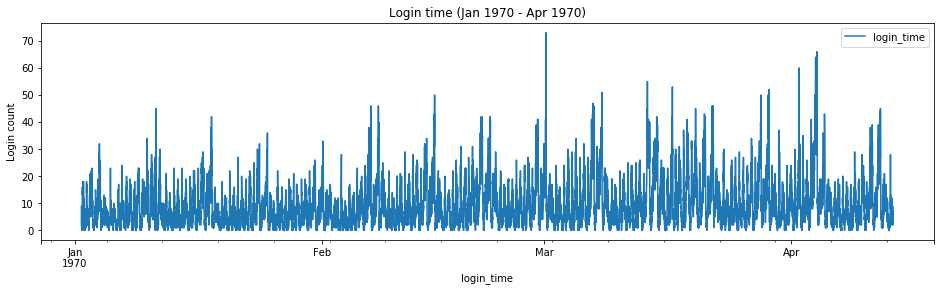

In [8]:
logins.plot(figsize=(16, 4))
plt.title('Login time (Jan 1970 - Apr 1970)')
plt.ylabel('Login count')
plt.show()

Text(0,0.5,'15 min interval')

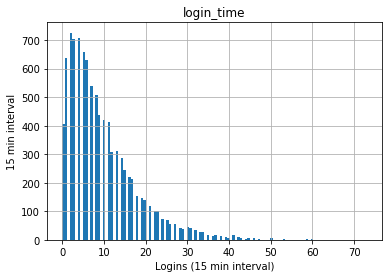

In [9]:
logins.hist(bins=120)
plt.xlabel('Logins (15 min interval)')
plt.ylabel('15 min interval')

Text(0,0.5,'Number of logins')

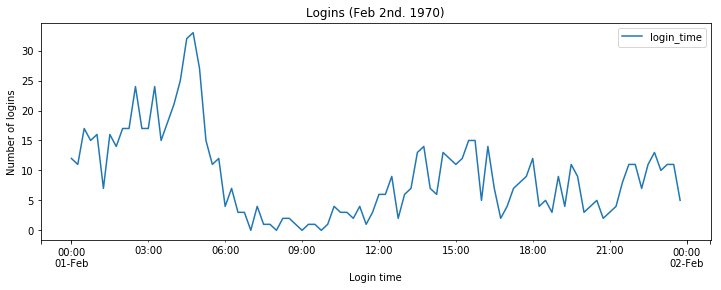

In [10]:
logins['1970-02-01': '1970-02-01'].plot(figsize=(12,4))
plt.title('Logins (Feb 2nd. 1970)')
plt.xlabel('Login time')
plt.ylabel('Number of logins')

Text(0,0.5,'Number of logins')

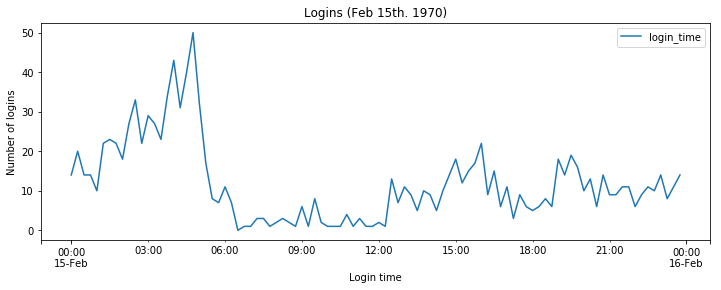

In [11]:
logins['1970-02-15': '1970-02-15'].plot(figsize=(12,4))
plt.title('Logins (Feb 15th. 1970)')
plt.xlabel('Login time')
plt.ylabel('Number of logins')

Text(0,0.5,'Number of logins')

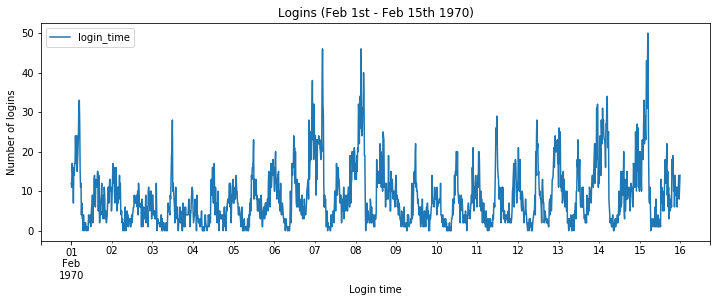

In [12]:
logins['1970-02-01': '1970-02-15'].plot(figsize=(12,4))
plt.title('Logins (Feb 1st - Feb 15th 1970)')
plt.xlabel('Login time')
plt.ylabel('Number of logins')

It can be identified a cyclical pattern in the data showing that activity increases by the end of the week and decreases during weekdays. It can also be observed that there is regular pattern within the day in which activity peaks at the early hours of the day (12:00pm - 5:00am). Then, the logins drastically fall during the early hours of the morning, probably because of these being work hours. Then, at noon activiy again peaks up to 3:00pm probably because of lunch time. Then, the logins decrease again and come back up around 5:00pm when people leave their work. Overall, it seems that this service is used for people working a 9am to 5pm shift and also by people partying on the weekends.  

## Part 2

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. How you will implement the experiment?

b. What statistical test(s) you will conduct to verify the significance of the
observation?

c. How you would interpret the results and provide recommendations to the city
operations team along with any caveats?

One way to measure if the toll subsidy has been succesful in encouraging driver partners to offer their service in both cities is to test the average time within a day they serve in each city. Based on the information on the prompt, it could be assume that drivers spend most of their working time only in one city. This is the key metric to evaluate. 

In order to test this, an experiment has to be set up where the experiment group corresponds to drivers who take the toll subsidy and the control group corresponds to those drivers who do not take this subsidy. The null and alternative hypotheses are expressed below:  

H0: There is not difference in the time spent in each city by drivers who to the subsidy and those who did not. 
H1: There is a difference in the time spent in each city by drivers who took the subsidy compared to those who did not. 

This experiment could run for a period of three months in order to control for seasonal effects; although it could be shorter depending on budget constraints. Also, the measurements need to separate weekdays from weekends since they show different patterns. 

The data for this experiment can be collected from the GPS tracker associated with the driver partner's account. Then, this data can be divide into two groups depending on vehicle's position with regard to the bridge. If this data were not available, the time in between toll tickets could also serve the present purposes. 

In order to test the hypotheses above, a pair t-test measuring the difference between mean time spent in each city will be carried away. Thus, this test assumes that the difference in mean time for drivers who took the subsidy and those who did not is zero. The p-value will be set at .05, as it is customary. A p-value smaller than .05 will suggest that there is reason to reject the null hypothesis. 

Should the null hypothesis be rejected, this would account as a reason to believe that the toll subsidy has a positive impact in encouraging drivers to operate in both cities. Therefore, it will be suggested that Ultimate implements the toll subsidy to the drivers of these two cities. In the event in which the p-value does not reach significancy, the recommendation would be not to implement the toll subsidy. 

In addition, it has to be kept in mind that other factors such as the day of the week (weekday vs. weekend) need to be assessed since they are very likely to play a roll in whether the driver partner operates in both cities. Other metrics that could also be analyzed is the average distance driven, the number of hours worked by the driver partner, and the number of customer signups for periods before and after the toll subsidy.

## Part 3

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

In [13]:
challenge.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [14]:
challenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [15]:
# Identify the period comprised in the data set and identify their type
print(challenge['last_trip_date'].min())
print(challenge['last_trip_date'].max())
print(type(challenge['last_trip_date'][0]))

2014-01-01
2014-07-01
<class 'str'>


In [16]:
# Create new column active_user: 1 if 'last trip date' higher than 2014-06-01, otherwise 0
#challenge['last_trip_date'] = challenge['last_trip_date'].apply(pd.to_datetime)

challenge['active_user'] = [1 if x >= '2014-06-01' else 0 for x in challenge['last_trip_date']]
print(challenge['active_user'].unique())

[1 0]


In [17]:
# Evaluate distribution of active vs. inactive users
print(challenge['active_user'].value_counts())
print('=' * 10)
print('non-active users:', 31196/len(challenge))
print('active users:', 18804/len(challenge))

0    31196
1    18804
Name: active_user, dtype: int64
non-active users: 0.62392
active users: 0.37608


Only 38% of users were ratained, measured by being active in the last 30 days. 

In [18]:
# Clean data set: drop na values
challenge = challenge.dropna()
challenge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 13 columns):
avg_dist                  41445 non-null float64
avg_rating_by_driver      41445 non-null float64
avg_rating_of_driver      41445 non-null float64
avg_surge                 41445 non-null float64
city                      41445 non-null object
last_trip_date            41445 non-null object
phone                     41445 non-null object
signup_date               41445 non-null object
surge_pct                 41445 non-null float64
trips_in_first_30_days    41445 non-null int64
ultimate_black_user       41445 non-null bool
weekday_pct               41445 non-null float64
active_user               41445 non-null int64
dtypes: bool(1), float64(6), int64(2), object(4)
memory usage: 4.2+ MB


In [19]:
# Create dummy variables for categorical variables
challenge_OHE = pd.get_dummies(challenge, prefix='OHE', columns=['city', 'phone','ultimate_black_user'])
challenge_OHE.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,weekday_pct,active_user,OHE_Astapor,OHE_King's Landing,OHE_Winterfell,OHE_Android,OHE_iPhone,OHE_False,OHE_True
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,46.2,1,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,50.0,0,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,100.0,0,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,80.0,1,0,1,0,0,1,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,82.4,0,0,0,1,1,0,1,0


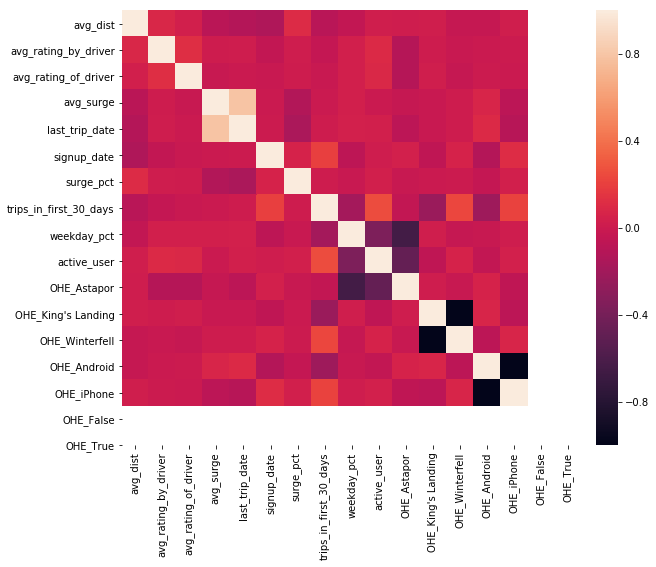

In [20]:
# Evaluate correlation on the different variables
plt.figure(figsize=(10, 8))
sns.heatmap(challenge_OHE.corr(), xticklabels=challenge_OHE.columns.values, yticklabels=challenge_OHE.columns.values)

In [21]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(challenge_OHE[challenge_OHE.columns.difference(['active_user', 'last_trip_date', 'signup_date'])], challenge_OHE['active_user'], test_size=0.25, random_state=123)

In [22]:
# Instantiate classifiers
classifiers = [linear_model.LogisticRegression(solver='lbfgs' , C=10000), 
              MultinomialNB(), 
              BernoulliNB(), 
              RandomForestClassifier(n_estimators=20, max_depth=30, random_state=30), 
              KNeighborsClassifier(), 
              SVC()]

In [23]:
# Define a function to run the classifiers
def run_classifiers(X_train, X_test, y_train, y_test, classifiers):
    # Create a dataframe with results
    results_cols = ['Classifier', 'Train score', 'Test score', 'Accuracy', 'Log Loss']
    results = pd.DataFrame(columns = results_cols)

    predictions_cols = ['Logistic_regression', 'MultinomialNB', 'BernoulliNB', 'RandomForest', 'KNeighbors', 'SVC']
    global predictions
    predictions = pd.DataFrame()

    for clf in classifiers:
        clf.fit(X_train, y_train)
    
        name = clf.__class__.__name__
    
        print('='*30)
        print(name)
    
        print('**** Results ****')
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        print('Train score: {:.4%}'.format(train_score))
        print('Test score: {:.4%}'.format(test_score))
    
        prediction = clf.predict(X_test)
        acc = accuracy_score(y_test, prediction)
        print("Accuracy: {:.4%}".format(acc))
        log_predictions = pd.DataFrame(prediction.tolist())
        predictions = pd.concat([predictions, log_predictions], axis = 1)
    
    
        try:
            train_predictions = clf.predict_proba(X_test)
            ll = log_loss(y_test, train_predictions)
            print("Log Loss: {}".format(ll))
        except:
            ll = 'Not applicable'
    
        #acc and ll have been removed
        log_entry = pd.DataFrame([[name, train_score, test_score, acc, ll]], columns = results_cols)
        results = results.append(log_entry)
        
    # Get results in one view
    print(results.head())
    predictions.columns = predictions_cols
    print('*' * 40)
    print(predictions.head())

In [24]:
# Run classifiers
run_classifiers(X_train, X_test, y_train, y_test, classifiers)

LogisticRegression
**** Results ****
Train score: 70.3278%
Test score: 71.0481%
Accuracy: 71.0481%
Log Loss: 0.567111024208042
MultinomialNB
**** Results ****
Train score: 65.5020%
Test score: 66.6860%
Accuracy: 66.6860%
Log Loss: 0.7768999444173165
BernoulliNB
**** Results ****
Train score: 70.8908%
Test score: 71.3858%
Accuracy: 71.3858%
Log Loss: 0.5721913809753065
RandomForestClassifier
**** Results ****
Train score: 99.1024%
Test score: 74.9180%
Accuracy: 74.9180%
Log Loss: 1.071655895936778
KNeighborsClassifier
**** Results ****
Train score: 81.6491%
Test score: 73.6151%
Accuracy: 73.6151%
Log Loss: 2.0454789881032056
SVC
**** Results ****
Train score: 80.4298%
Test score: 75.4102%
Accuracy: 75.4102%
               Classifier  Train score  Test score  Accuracy  Log Loss
0      LogisticRegression     0.703278    0.710481  0.710481  0.567111
0           MultinomialNB     0.655020    0.666860  0.666860    0.7769
0             BernoulliNB     0.708908    0.713858  0.713858  0.572191


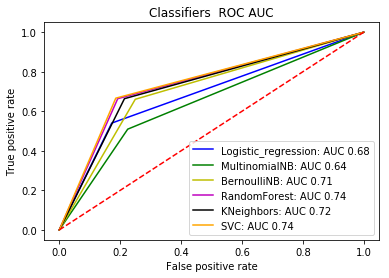

In [25]:
# ROC curve
cmp = 0
colors = ['b', 'g', 'y', 'm', 'k', 'orange']
for model, predict in predictions.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers  ROC AUC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.show()

In [26]:
# Tune hyper-parameters for the best classifier: RandomForestClassifier
params_grid = {'n_estimators': [30, 60, 100], 'max_depth': [35, 40, 50]}

grid = GridSearchCV(RandomForestClassifier( random_state=30), params_grid, cv=10)
grid.fit(X_train, y_train)

best_forest_grid = grid.best_estimator_

# Review scores
print('train data score:', best_forest_grid.score(X_train, y_train))
print('test data score:', best_forest_grid.score(X_test, y_test))

train data score: 0.9976514493453013
test data score: 0.7540050183362286


In [27]:
best_forest_grid

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=30, verbose=0, warm_start=False)

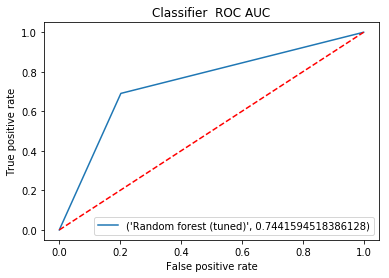

In [28]:
# ROC curve for tuned randomforest classifier

rf_cv_prediction = best_forest_grid.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf_cv_prediction)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, label=('Random forest (tuned)', roc_auc))


plt.title('Classifier  ROC AUC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.show()

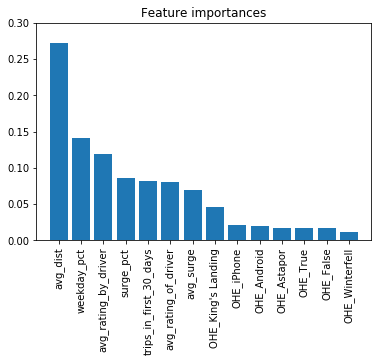

In [29]:
# Identify the 10 most import features
importances = np.asarray(sorted(best_forest_grid.feature_importances_, reverse=True)[:14])
indices = np.argsort(importances)[::-1]

# Create labels
X_train = [str(i) for i in X_train]
feature_importance_values = list(zip(best_forest_grid.feature_importances_, X_train))
features = sorted(feature_importance_values, key = lambda x: x[0], reverse=True)[:14]
labels = [x[1] for x in features]

# Plot 30 most important features
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), labels, rotation=90)
plt.xlim([-1, 14])
plt.ylim([0, 0.30])
plt.show()

In [30]:
challenge.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,active_user
count,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000
mean,5.460046,4.776446,4.601720,1.073822,8.898709,2.609675,61.254897,0.411027
std,5.145174,0.404606,0.616104,0.198747,18.322061,4.059336,34.813848,0.492026
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,37.500000,0.000000
50%,3.780000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000,0.000000
75%,6.490000,5.000000,5.000000,1.070000,11.100000,3.000000,100.000000,1.000000
max,79.690000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.000000


For building a model to predict whether a customer will be active after the six month of signing up, 6 different classifiers were built first to test their performance. From these models, the random forest classifier performed the best and was then further tuned to find the best hyperparameters. Then, the results of this tuned classifier were cross-validared with 10 k-folds. The cross-validated result was .75 accuracy and .74 ROC AUC on the test data. 

From this model, the best predictors found were average distance per trip (in miles), the percentage of user's trips occurring in weekdays, and the rider's average rating. 

In order to improve long term rider retention, it is important to strengthen those aspects of the bussiness model that are currently working in retaining users. It is suggested that Ultimate focuses on customers using the service mostly during weekdays and further attract them. In addiiton, a promotion encouraging larger trips in terms in miles could also help in customer loyalty. Finally, incentivizing the customer to use the service in their first 30 days after signing up could also improve customer retention. 